In [1]:
import tensorflow as tf
import librosa
from models.autoencoder import * 
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load style and content

In [2]:
CONTENT_FILENAME = "inputs/original_inputs/imperial.mp3"
STYLE_FILENAME = "inputs/original_inputs/usa.mp3"

In [3]:
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))

In [4]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

In [5]:
a_content, fs = read_audio_spectum(CONTENT_FILENAME)
a_style, fs = read_audio_spectum(STYLE_FILENAME)

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]
a_style = a_style[:N_CHANNELS, :N_SAMPLES]

### Visualize spectrograms for content and style tracks

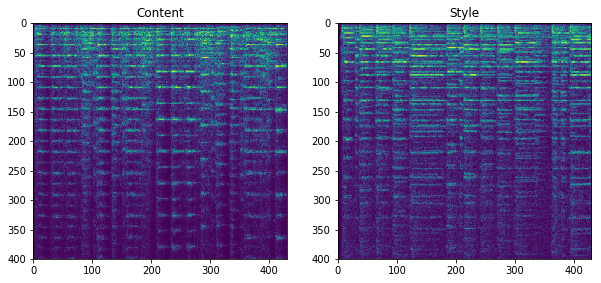

In [6]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.show()

### Compute content and style feats

In [7]:
input_batch_placeholder = tf.placeholder(tf.float32, shape=(2, N_SAMPLES, N_CHANNELS), name="input_batch")
ae_outputs, layer_features, loss = seq2seq_ae_with_loss(input_batch_placeholder, seq_lengths= \
                                               tf.constant(np.array([N_SAMPLES, N_SAMPLES])), training=True)
input_batch = np.array([a_style.T, a_content.T])

train_op = tf.train.AdamOptimizer(1e-3).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(250):
    _, step_loss = sess.run([train_op, loss], feed_dict={input_batch_placeholder:input_batch})
    print("iteration {}, loss: {}".format(i, step_loss))

content_features = sess.run(layer_features[2], feed_dict={input_batch_placeholder:input_batch})[1, :, :]
style_features = sess.run(layer_features[1], feed_dict={input_batch_placeholder:input_batch})[0, :, :]

features = style_features # np.reshape(style_features, (-1, N_FILTERS))
style_gram = np.matmul(features.T, features) / N_SAMPLES

iteration 0, loss: 167730.0
iteration 1, loss: 161447.21875
iteration 2, loss: 139493.140625
iteration 3, loss: 115880.40625
iteration 4, loss: 106695.28125
iteration 5, loss: 98861.4140625
iteration 6, loss: 93985.859375
iteration 7, loss: 89768.765625
iteration 8, loss: 88914.5859375
iteration 9, loss: 87078.6171875
iteration 10, loss: 84443.28125
iteration 11, loss: 83583.5859375
iteration 12, loss: 82355.3125
iteration 13, loss: 80583.0234375
iteration 14, loss: 79507.46875
iteration 15, loss: 78402.171875
iteration 16, loss: 76941.796875
iteration 17, loss: 75610.3671875
iteration 18, loss: 74388.3359375
iteration 19, loss: 73015.40625
iteration 20, loss: 71521.7265625
iteration 21, loss: 69998.2109375
iteration 22, loss: 68351.390625
iteration 23, loss: 66649.3125
iteration 24, loss: 64876.6445312
iteration 25, loss: 62934.8710938
iteration 26, loss: 60893.7265625
iteration 27, loss: 58766.421875
iteration 28, loss: 56486.8125
iteration 29, loss: 54089.5
iteration 30, loss: 51611

In [12]:
print(sess.run([tf.shape(ae_outputs)]))

[array([   2,  430, 1025], dtype=int32)]


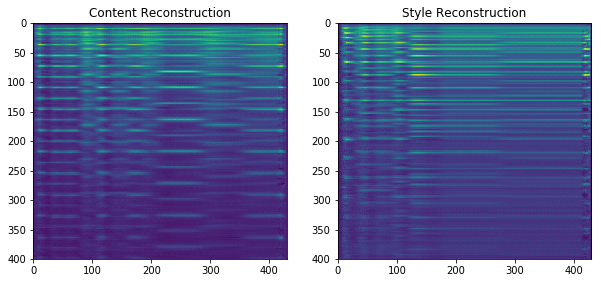

In [9]:
reconstruction = sess.run(ae_outputs, feed_dict={input_batch_placeholder:input_batch})
reconstruction = np.transpose(reconstruction, (0, 2, 1))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content Reconstruction')
plt.imshow(reconstruction[1, :400,:])
plt.subplot(1, 2, 2)
plt.title('Style Reconstruction')
plt.imshow(reconstruction[0, :400,:])
plt.show()

In [11]:
recon = np.zeros_like(a_content)
recon[:N_CHANNELS,:] = np.exp(reconstruction[1]) - 1 # np.exp(result[0,0].T) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(recon.shape) - np.pi
for i in range(500):
    S = recon * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = 'outputs/content_reconstruction.wav'
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)
print OUTPUT_FILENAME
display(Audio(OUTPUT_FILENAME))

outputs/content_reconstruction.wav


### Optimize

In [ ]:
from sys import stderr

ALPHA= 1e-2
learning_rate= 1e-3
iterations = 300

result = None

# Build graph with variable input
#  x = tf.Variable(np.zeros([1,1,N_SAMPLES,N_CHANNELS], dtype=np.float32), name="x")
x = tf.Variable(np.random.randn(1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x")

_, layer_features, loss = seq2seq_ae_with_loss(x, seq_lengths= \
                                           tf.constant(np.array([N_SAMPLES])), training=False)

x_content_features = layer_features[2]
x_style_features = layer_features[1]

feats = tf.reshape(x_style_features, (N_SAMPLES, N_CHANNELS))
gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES

content_loss = ALPHA * 2 * tf.nn.l2_loss(
        x_content_features - content_features)
style_loss = 2 * tf.nn.l2_loss(x_style_features - style_gram)

 # Overall loss
loss = content_loss + style_loss

opt = tf.contrib.opt.ScipyOptimizerInterface(
      loss, method='L-BFGS-B', options={'maxiter': 300})

# Optimization
sess.run(tf.initialize_all_variables())

print('Started optimization.')
opt.minimize(sess)

print 'Final loss:', loss.eval()
result = x.eval()

### Invert spectrogram and save the result

In [ ]:
a = np.zeros_like(a_content)
a[:N_CHANNELS,:] = np.exp(result[0].T) - 1 # np.exp(result[0,0].T) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = 'outputs/out.wav'
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)
print OUTPUT_FILENAME
display(Audio(OUTPUT_FILENAME))

### Visualize spectrograms

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1,3,2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.subplot(1,3,3)
plt.title('Result')
plt.imshow(a[:400,:])
plt.show()